In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# the files containing the '.npy' files needed for problem 2
# e.g. '/content/drive/MyDrive/cs231a'
FOLDERNAME = 'haber_research'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/MyDrive/haber_research/box_data/raw_film
print('Files in this folder:')
%ls .

**FC103_F05.MOV**

In [ ]:
from google.colab.patches import cv2_imshow
import os
import cv2

In [ ]:
filename = "WB026F01_1of2.mov"
file_path = os.path.join("/content/drive/MyDrive/haber_research/box_data/raw_film", filename)
folder_name = '/content/drive/MyDrive/frames_WB026F01_1of2.mov'
interval = 3

# Open the video file
cap = cv2.VideoCapture(file_path)

# Get the frames per second (fps) and total number of frames
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Calculate the frame interval in frames
frame_interval = int(fps * interval)

# Extract and save one frame at each specified time interval
for i in range(0, total_frames, frame_interval):
    # Set the frame position and read the frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    success, frame = cap.read()

    # If frame reading was successful, save the frame
    if success:
        frame_name = f"frame_{i}.jpg"
        frame_path = os.path.join(folder_name, frame_name)
        cv2.imwrite(frame_path, frame)

cap.release()


In [ ]:
num_files = len(os.listdir(folder_name))
print(num_files)

227


imports for **CLIP**

In [ ]:
!pip install transformers
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from transformers import CLIPProcessor, CLIPModel
import torch.nn.functional as F


In [ ]:
device = 'cuda'
!pip install git+https://github.com/openai/CLIP.git
import clip
clip.available_models()
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = 'ViT-L/14@336px'
model, preprocess = clip.load(model_name, device=device)



text prompt

In [ ]:
text_prompt = [
    "a photograph of an adult and a child both LOOKING at the SAME object",
    "a photograph of an adult and children LOOKING at each other",
]
text_input = clip.tokenize(text_prompt).to(device)


In [ ]:
import os

root_dir = "/content/drive/MyDrive/unzipped/annotation/frames_FC174F01_1of2.mov"

"""Pad a PIL Image to make it square."""

In [ ]:
def pad_to_square(image, color=(0, 0, 0)):
    """Pad a PIL Image to make it square."""
    width, height = image.size
    if width == height:
        return image
    elif width > height:
        new_height = width
        new_width = width
    else:
        new_width = height
        new_height = height
    new_image = Image.new(image.mode, (new_width, new_height), color)
    new_image.paste(image, ((new_width - width) // 2, (new_height - height) // 2))
    return new_image

In [ ]:
similarity_scores = []
filenames=[]
def get_sims(root_dir, text_input):
    for filename in os.listdir(root_dir):
        if filename.endswith(".jpg"):
            # Load the image and encode it using the processor
            image_path = os.path.join(root_dir, filename)
            image = pad_to_square(Image.open(image_path))
            image_input = preprocess(image).to(device).unsqueeze(0)
            image_embedding = model.encode_image(image_input)
            image_embeddings = F.normalize(image_embedding, p=2, dim=1)

            # Calculate the similarity score between the image and text
            text_embedding = model.encode_text(text_input)
            text_embeddings = F.normalize(text_embedding, p=2, dim=1)
            similarity_score = (image_embeddings @ text_embeddings.T).max().item()
            filenames.append(filename)

            similarity_scores.append(similarity_score)
            print(similarity_score)
    return similarity_scores

In [ ]:
yes=get_sims(root_dir, text_input)
df = pd.DataFrame(columns=["filename", "similarity"])
df["filename"] = filenames
df["similarity"] = yes





In [ ]:
df

,filename,similarity
0,frame_0.jpg,0.190552
1,frame_89.jpg,0.158691
2,frame_178.jpg,0.215210
3,frame_267.jpg,0.205811
4,frame_356.jpg,0.215088
...,...,...
222,frame_19758.jpg,0.188721
223,frame_19847.jpg,0.193604
224,frame_19936.jpg,0.170654
225,frame_20025.jpg,0.183716


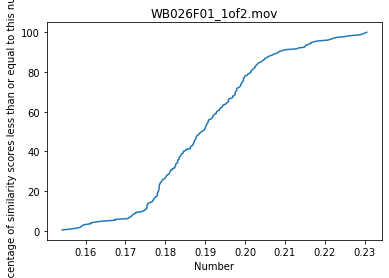

In [ ]:
import matplotlib.pyplot as plt

# Sort the list
sorted_numbers = sorted(yes)

# Get the total number of elements in the list
total_count = len(sorted_numbers)

# Initialize empty lists for x and y values
x_values = []
y_values = []

# Loop through the sorted list and calculate the percentage of numbers less than or equal to each number
for i, num in enumerate(sorted_numbers):
    # Calculate the percentage
    percent = (i + 1) / total_count * 100
    
    # Append to the x and y lists
    x_values.append(num)
    y_values.append(percent)

# Plot the line chart
plt.plot(x_values, y_values)
plt.xlabel('Number')
plt.ylabel('Percentage of similarity scores less than or equal to this number')
plt.title("WB026F01_1of2.mov")

plt.show()

In [ ]:
raw_film_folder = "/content/drive/MyDrive/haber_research/box_data/raw_film"
filenames_list=[]
for filename in os.listdir(raw_film_folder):
  filenames_list.append(filename)

for filename in filenames_list:
    folder_name = f"frames_{filename}"
    folder_path = os.path.join("/content/drive/MyDrive", folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Created folder '{folder_name}' in Google Drive.")

folder name

In [ ]:
folder_list=[]
for filename in filenames_list:
    folder_name = f"frames_{filename}"
    folder_list.append(folder_name)

In [ ]:
df2 = pd.DataFrame(columns=["folder_names", "file_name"])
df2["folder_names"] = folder_list
df2["file_name"] = filenames_list

In [ ]:
df2
df2 = df2[~df2["file_name"].str.endswith('.jpg')]
df2

In [ ]:
for i in range(len(df2)):
    file_name = df2.loc[i, 'file_name']
    folder_name = df2.loc[i, 'folder_names']
    print(file_name,folder_name)

In [ ]:
import cv2
import os

# loop through each row and define file_name and folder_name
for i in range(len(df2)):
    file_name = df2.loc[i, 'file_name']
    file_path = os.path.join("/content/drive/MyDrive/haber_research/box_data/raw_film", file_name)
    folder_name = df2.loc[i, 'folder_names']
    folder_name = os.path.join("/content/drive/MyDrive",folder_name)
    #print(file_name,folder_name)

    interval = 3

    # Open the video file
    cap = cv2.VideoCapture(file_path)

    # Get the frames per second (fps) and total number of frames
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the frame interval in frames
    frame_interval = int(fps * interval)

    # Extract and save one frame at each specified time interval
    for j in range(0, total_frames, frame_interval):
        # Set the frame position and read the frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, j)
        success, frame = cap.read()

        # If frame reading was successful, save the frame
        if success:
            frame_name = f"frame_{j}.jpg"
            frame_path = os.path.join(folder_name, frame_name)
            cv2.imwrite(frame_path, frame)

    cap.release()